# Basic K-Means Clustering

##### Note: must run [pip install whoosh], [pip install transformations]

In [35]:
from whoosh import index, writing, scoring
from whoosh.fields import Schema, TEXT, KEYWORD, ID, STORED
from whoosh.analysis import *
from whoosh.qparser import QueryParser
import os.path
from pathlib import Path
import tempfile
import subprocess
import csv
import codecs
import pandas as pd
import re
import os.path
from nltk.tokenize import RegexpTokenizer
import numpy as np
from sklearn import preprocessing
import transformations as trafo
import matplotlib.pyplot as plt
from collections import Counter

In [2]:
# SETTINGS
# Paths
DIRECTORY = ""
OUTPUT = os.path.join(DIRECTORY, "output.csv")

# Debugging - print entire array
np.set_printoptions(threshold=np.nan)

## Step 1:
### Lower case, remove punctuation, stemming, remove stop words

In [3]:
def createIndex(schema):
    # Generate a temporary directory for the index
    indexDir = tempfile.mkdtemp()

    # create and return the index
    return index.create_in(indexDir, schema)


def addFilesToIndex(indexObj, csvPath):
    # open writer
    writer = indexObj.writer()

    # open csv
    with codecs.open(csvPath, "r", "ISO-8859-1") as csvfile:
        # create csv reader object
        csvreader = csv.DictReader(csvfile)
        # create dictionary to hold document values
        doc = {}
        # instantiate index count
        i = 0
        
        # read each row in file
        for row in csvreader:
            value = row["Negative Feedback"]
            if value != "" and isinstance(value, str):
                doc[i] = value
                writer.update_document(index = str(i), cell_content = value)
            i += 1
        writer.commit()

In [4]:
# create text analyzer
cleaningFilter = RegexTokenizer() | LowercaseFilter() | IntraWordFilter() | StopFilter() | StemFilter()

# define a Schema with the new analyzer
schema = Schema(index = ID(stored=True),
                   cell_content = TEXT(analyzer = cleaningFilter, stored = True))

# create the index based on the new schema
index2 = createIndex(schema)

# index cell contents in refined.csv to index2
# TODO: put index2 into dataframe
addFilesToIndex(index2, OUTPUT)

# define a reader object on the index
myReader = index2.reader()

#### Inspect Index

In [102]:
# Is it empty?
print("Index is empty?", index2.is_empty())

# How many cells indexed?
print("Number of indexed files:", index2.doc_count())

# First 25 documents
#[(docnum, doc_dict) for (docnum, doc_dict) in myReader.iter_docs()][0:25]

# list indexed terms for field "cell_content"
all_words = [term for term in myReader.field_terms("cell_content")]

# Term frequency for a given term
print(myReader.frequency("cell_content", "android"))

# 1000 most distinctive terms according by TF-IDF score
mostDistinctiveWords = [term.decode("ISO-8859-1") for (score, term) in myReader.most_distinctive_terms("cell_content", 1000)]
# mostDistinctiveWords

# 1000 most frequent words
mostFrequentWords = [term.decode("ISO-8859-1") for (frequency, term) in myReader.most_frequent_terms("cell_content", 1000)]
# mostFrequentWords

Index is empty? False
Number of indexed files: 1110
47.0


In [82]:
# Create a binary encoding of dataset based on the selected features (X)
# go through each document --> tokenize that single document --> compare with total word list
# TODO: change to frequency encoding
tokenizer = RegexpTokenizer(r'\w+')
df_rows = []

word_list = mostFrequentWords

with codecs.open(OUTPUT, "r", "ISO-8859-1") as csvfile:
    csvreader = csv.DictReader(csvfile)
    for i, row in enumerate(csvreader):
        value = row["Negative Feedback"]
        if value != "" and isinstance(value, str):
            file_words = tokenizer.tokenize(value)
            df_rows.append([1 if word in file_words else 0 for word in word_list]) 
    X = pd.DataFrame(df_rows, columns = word_list)

In [83]:
# convert to numpy array
data = np.array(df_rows)

X_normalized = preprocessing.normalize(data, norm='l2')

## Step 2

### K-means Clustering (Scikit-learn)
##### Note: must run pip install scikit-learn, pip install scipy

In [84]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from scipy.cluster import hierarchy

num_clusters = 20

# Number of clusters
kmeans = KMeans(n_clusters=num_clusters)
# Fitting the input data
kmeans = kmeans.fit(X_normalized)
# Getting the cluster labels
labels = kmeans.predict(X_normalized)
# Centroid values
centroids = kmeans.cluster_centers_
labels = kmeans.labels_

# print(centroids)
print(labels)

[10  2 10 13  3 18 16  1 19  0 12 10 10 10  3 17  5 12 10 17  2  3 17 11
  3  2 10  6  3 10 10  9 13  8  8  3 12  2 11  3  2 13  3 13  5  8 10 13
 10 18  3  2  1  3  5 17 15 19  5  2  3  3 10 13 10  3  2 10 10  5 15 10
 12 10  1  6  0  1 12  6  3  9 18  3 18 18  5  5  8  2  0  1  1 19  1 12
 16 17 17  3 10  5 13 11  2  3  9  6  2  2 17 12 15 10 11  6 16 15  5 10
  3 16  1 15 11 17 10 10  1  2  3 12 13  9 18 13  3  9 11  3  3 12  3 10
  2  1 12  8 12  2 14  3 12  3 12  5  9  3 14  2  1 10 10  1  3  2 19 10
  6 10  2 10  8  8 19  3  3  3 19  8 10 13 11 11  3 10  1  5  3 16  2  3
  6 16 10  3  3  5 10 12  3  3 10 10  8  3 17  3  1  6 11 17 17  3 10  2
 13 15  3 11 10  5  2 19  2  2  5 16  1  5  0 10  1 16 16  2  3  3 11 16
  5  1  1 13 12 16 15 16 16 14 10 13  2 18 10 18  2 11 11 12 10 11  9  9
  5  3  3 19  3 10  2  0  6 15 10  3  8 17  1 17  3  1 15 19 17 10 17  2
 16  5  2  2  2  6 10 13 10  2 17  3 19  3 12 11  3 17  2 18  1 10  3 18
 14  5 13  2  3  3 16 10 10  3 10 10  3  8  1  3 14

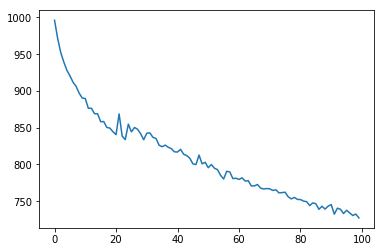

In [101]:
# Find best k for clusters (elbow method)
inertia = []

for i in range(100):
    # Number of clusters
    kmeans = KMeans(n_clusters=i+1)
    # Fitting the input data
    kmeans = kmeans.fit(X_normalized)
    # Calculate inertia (within-cluster sum-of-squares)
    inertia.append(kmeans.inertia_)

plt.plot(inertia)

<BarContainer object of 20 artists>

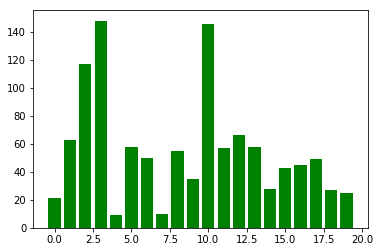

In [85]:
unique, counts = np.unique(kmeans.labels_, return_counts=True)
clusterCount = dict(zip(unique, counts))
plt.bar(clusterCount.keys(), clusterCount.values(), color='g')

In [93]:
# See top 5 vectors closest to cluster centroid j

for j in range(num_clusters):
    d = kmeans.transform(X_normalized)[:, j]
    ind = np.argsort(d)[::-1][:5]
    print("Cluster", j)
    print("Indices of top 5 documents:", ind)
    print(np.array([doc_dict for doc_dict in myReader.iter_docs()])[ind]) 


# j = 2

# # the distance to the j'th centroid for each point in an array X 
# d = kmeans.transform(X_normalized)[:, j]
# ind = np.argsort(d)[::-1][:5]
# print("Cluster", j)
# print("Indices of top 5 documents:", ind)
# print(np.array([doc_dict for doc_dict in myReader.iter_docs()])[ind])
# X_normalized[ind]

Cluster 0
Indices of top 5 documents: [ 24 188 263 402 457]
[[24
  {'cell_content': 'The constant harassment for feedback is a pain. Happy holidays', 'index': '50'}]
 [188
  {'cell_content': 'hai boschetarule , lasa cenzura penala si lasa internetul liber sa mearga ,analfabetule LUATEAR DRACU BELITULE ,PROSTANAC CENZURATOR PENAL', 'index': '360'}]
 [263
  {'cell_content': 'Pages are slow to load compared to chrome ', 'index': '491'}]
 [402
  {'cell_content': 'Freezes, slows down the phone and tablet.', 'index': '766'}]
 [457
  {'cell_content': "CSS3 transitions rendering is bad (display doesn't refresh properly)", 'index': '875'}]]
Cluster 1
Indices of top 5 documents: [1109  236 1088  261  275]
[[1109
  {'cell_content': 'The layout is not very intuitive.', 'index': '2225'}]
 [236 {'cell_content': 'Bookmarks disappear each day.', 'index': '442'}]
 [1088
  {'cell_content': 'Always crashes at android devices with low memory', 'index': '2156'}]
 [261
  {'cell_content': 'Updated flashplaye

[[1109
  {'cell_content': 'The layout is not very intuitive.', 'index': '2225'}]
 [402
  {'cell_content': 'Freezes, slows down the phone and tablet.', 'index': '766'}]
 [878
  {'cell_content': 'google search not working properly :( ', 'index': '1735'}]
 [877
  {'cell_content': 'When navigating multiple websites using multiple tabs Firefox takes up far too much memory RAM. Keith.buckner@it911now.com 619-377-8911.', 'index': '1728'}]
 [1043
  {'cell_content': 'Firefox for Android has a setting to set your homepage (Settings / General / Home / Set a Homepage).  Nice bit of useless UI, that. It does NOTHING.', 'index': '2075'}]]
Cluster 19
Indices of top 5 documents: [1109  912  184  941  188]
[[1109
  {'cell_content': 'The layout is not very intuitive.', 'index': '2225'}]
 [912
  {'cell_content': 'I mangler at oversÃ¦tte det meste af jeres support sider! ', 'index': '1812'}]
 [184
  {'cell_content': 'Scrolling with mouse wheel crashes Firfox ', 'index': '352'}]
 [941
  {'cell_content': "T

In [ ]:
# Spectral Clustering

# from sklearn.cluster import SpectralClustering
# from sklearn.metrics.pairwise import pairwise_distances

In [ ]:
# similarity_matrix = 1 - pairwise_distances(df_rows, metric='cosine')
# cosineScores = pd.DataFrame(similarity_matrix)
# clusters = SpectralClustering(n_clusters = 5, affinity = 'precomputed').fit(cosineScores)

## Step 3 Cluster Visualization

In [ ]:
# %matplotlib inline

# import seaborn as sns; sns.set()
# import pprint

In [ ]:
# def fit_and_plot(algorithm,title):
#     col = ['bo','ro','co', 'mo','ko']
#     algorithm.fit(X)
#     n_clusters = algorithm.n_clusters
#     lab = algorithm.labels_
#     reds = lab == 0
#     blues = lab == 1
#     for jj in range(n_clusters):
#         plt.plot(X[lab == jj, 0], X[lab == jj, 1], col[jj])
#     plt.xlabel("$x_1$")
#     plt.ylabel("$x_2$")
#     plt.title(title)
#     plt.axes().set_aspect('equal')   

In [ ]:
# pp = pprint.PrettyPrinter(indent=4)
# pp.pprint(clusters.get_params())
# fit_and_plot(clusters,"Spectral clustering on two circles")

In [ ]:
# y_kmeans = kmeans.predict(X)
# plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')

# centers = kmeans.cluster_centers_
# plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

## Step 4 Label Clusters with Key Words

### TF-IDF Frequency Normalization

In [ ]:
# pull out documents of each cluster --> tf idf for key words

test_cluster = 12

# indices for cluster 0
indices = [index for index, clusterNum in enumerate(labels) if clusterNum == test_cluster]

# documents in cluster 0
clusterCorpus = [doc_dict['cell_content'] for (docnum, doc_dict) in myReader.iter_docs() if docnum in indices]
print(clusterCorpus)

In [ ]:
vectorizer = TfidfVectorizer(stop_words='english')
# X_tf = vectorizer.fit_transform(clusterCorpus)

response = vectorizer.transform(clusterCorpus)
feature_names = vectorizer.get_feature_names()

In [ ]:
feature_array = np.array(vectorizer.get_feature_names())
tfidf_sorting = np.argsort(response.toarray()).flatten()[::-1]

# TODO

n = 10
top_n = feature_array[tfidf_sorting][:n]

feature_array[tfidf_sorting]

# print(top_n)